In [7]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import numpy as np
from time import sleep
from tqdm.notebook import trange, tqdm

In [2]:
def team_records(season):
    url = f'https://www.basketball-reference.com/leagues/NBA_{season}.html'
    soup_obj = BeautifulSoup(urlopen(url), 'html.parser')
    table_html = soup_obj.findAll('table', id = re.compile('advanced-team'))[0].findAll('a')
  
    global team_abrv
    team_name, team_abrv = [],[]
    
    for html in table_html:
        abrv = html.get('href')
        pattern = re.compile(r'([A-Z]{3})')
        team_abrv.append(pattern.search(abrv).group())
        team_name.append(html.text)
    
    team_abrv = list(zip(team_name,team_abrv))

    table = soup_obj.findAll('table', id = re.compile('advanced-team'))
    team_records = pd.read_html(str(table))[0]
  
    team_records = team_records.apply(pd.to_numeric, errors = 'coerce').fillna(team_records)
    team_records.columns = team_records.columns.droplevel(0)
    team_records = team_records.drop(['Rk', 'PW', 'PL', 'Arena', 'Attend.', 'Attend./G'], 1) 
    team_records.Team = team_records.Team.str.replace('*','')
  
    for index in range(20,24):
        if index != 22:
            team_records.columns.values[index] = 'Opp_' + team_records.columns.values[index] 
  
    team_records = team_records.drop(['Unnamed: 17_level_1','Unnamed: 22_level_1','Unnamed: 27_level_1'],1)
    team_records = team_records[:-1]
    
    team_names = [i[0] for i in team_abrv]
    team_abbrevation = [i[1] for i in team_abrv]
    
    for team,i in zip(team_records.Team,team_records.index.values): 
        if team in team_names:
            idx = (team_names.index(team))
            team_records.Team[i] = team_abbrevation[idx]
        else:
            pass
        
    for col in team_records.columns[1:]:
        team_records[col] = team_records[col].replace(',', '.').astype(float)
    
    team_records['SOY'] = team_records.nlargest(5,'SRS')['SRS'].sum()/team_records['Team'].count()
   
    team_records['Net_Four_Factors_Rating'] = (0.4*team_records['eFG%'] - 0.25*team_records['TOV%'] + 0.2*team_records['ORB%'] + 0.15*team_records['FT/FGA']) - (0.4*team_records['Opp_eFG%'] - 0.25*team_records['Opp_TOV%'] + 0.2*(100-team_records['DRB%']) + 0.15*team_records['Opp_FT/FGA'])      
    team_records["Updated_Four_Factors_Rating"] = (0.5*team_records['eFG%'] - 0.3*team_records['TOV%'] + 0.15*team_records['ORB%'] + 0.05*team_records['FT/FGA']) - (0.5*team_records['Opp_eFG%'] - 0.3*team_records['Opp_TOV%'] + 0.15*(100-team_records['DRB%']) + 0.05*team_records['Opp_FT/FGA'])
    
    return team_records

In [3]:
pd.set_option('max_columns', None)
team_records(2020)

C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  team_records = team_records.drop(['Rk', 'PW', 'PL', 'Arena', 'Attend.', 'Attend./G'], 1)
C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  team_records.Team = team_records.Team.str.replace('*','')
C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  team_records = team_records.drop(['Unnamed: 17_level_1','Unnamed: 22_level_1','Unnamed: 27_level_1'],1)


,Team,Age,W,L,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,Opp_eFG%,Opp_TOV%,DRB%,Opp_FT/FGA,SOY,Net_Four_Factors_Rating,Updated_Four_Factors_Rating
0,MIL,29.2,56.0,17.0,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,1.138333,0.26365,0.10765
1,BOS,25.3,48.0,24.0,6.31,-0.47,5.83,113.3,107.0,6.3,99.5,0.259,0.386,0.570,0.531,12.2,23.9,0.207,0.509,13.5,77.4,0.215,1.138333,0.59260,0.59560
2,LAC,27.4,49.0,23.0,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,1.138333,0.13565,0.06085
3,TOR,26.6,53.0,19.0,6.24,-0.26,5.97,111.1,105.0,6.1,100.9,0.264,0.421,0.574,0.536,13.1,21.3,0.210,0.502,14.6,76.7,0.202,1.138333,-0.01020,0.16740
4,LAL,29.5,52.0,19.0,5.79,0.49,6.28,112.0,106.3,5.7,100.9,0.276,0.358,0.573,0.542,13.3,24.5,0.201,0.515,14.1,78.8,0.205,1.138333,0.87020,0.74830
5,DAL,26.1,43.0,32.0,4.95,-0.07,4.87,116.7,111.7,5.0,99.3,0.264,0.457,0.581,0.545,11.2,23.2,0.206,0.525,10.6,77.7,0.175,1.138333,0.04265,-0.03345
6,MIA,25.9,44.0,29.0,2.95,-0.35,2.59,112.5,109.5,3.0,98.3,0.299,0.419,0.587,0.547,13.5,20.3,0.234,0.523,12.6,79.5,0.213,1.138333,-0.25225,-0.28695
7,HOU,29.2,44.0,28.0,2.96,0.17,3.13,112.9,110.1,2.8,103.7,0.288,0.501,0.578,0.537,12.6,21.0,0.228,0.529,13.7,75.6,0.197,1.138333,-0.39715,-0.17445
8,UTA,27.3,44.0,28.0,2.47,0.05,2.52,112.3,109.9,2.4,98.6,0.268,0.414,0.585,0.549,13.7,21.6,0.208,0.518,11.1,78.9,0.185,1.138333,-0.53415,-0.68835
9,PHI,26.3,43.0,30.0,2.38,-0.13,2.25,111.3,109.0,2.3,99.0,0.255,0.360,0.566,0.534,12.7,23.9,0.193,0.523,12.5,80.3,0.214,1.138333,0.79125,0.57445


In [4]:
def playoff_records(season):
    url = f'https://www.basketball-reference.com/playoffs/NBA_{season}.html'

    table = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))
    playoff_records = pd.read_html(str(table))[0]
  
    playoff_records = playoff_records.apply(pd.to_numeric, errors = 'coerce').fillna(playoff_records)

    playoff_records.columns = playoff_records.columns.droplevel(0)
    
    if 'Team' in playoff_records.columns:
        playoff_records = playoff_records.loc[:,['Team','W','L']]
    else:
        playoff_records = playoff_records.loc[:,['Tm','W','L']]
        playoff_records.columns = ['Team','W','L']
        
        
    playoff_records = playoff_records[:-1]
    playoff_records.Team = playoff_records.Team.str.replace('*','')
    
    playoff_records['Champion_Share_Score'] = playoff_records['W']/max(playoff_records['W'])
    
    drop_col = ['W','L']
    playoff_records.drop(drop_col, axis="columns", inplace=True)

    team_names = [i[0] for i in team_abrv]
    team_abbrevation = [i[1] for i in team_abrv]
    index_list = []
    
    for team,i in zip(playoff_records.Team,playoff_records.index.values): 
        if team in team_names:
            idx = team_names.index(team)
            index_list.append(idx)
            playoff_records['Team'].replace(team, team_abbrevation[idx], inplace=True)
        else:
            pass
    
    for team in team_abbrevation:
        if team_abbrevation.index(team) not in index_list:
            playoff_records.loc[len(playoff_records.index)] = [team,0]            
    
    playoff_records = playoff_records.sort_values(by=['Champion_Share_Score'],ascending = False)
    
    return playoff_records

In [14]:
playoff_records(1998)

C:\Users\tmana\AppData\Local\Temp\ipykernel_38864\305103440.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  playoff_records.Team = playoff_records.Team.str.replace('*','')


,Team,Champion_Share_Score
0,CHI,1.0
3,UTA,0.866667
2,IND,0.666667
5,LAL,0.466667
1,SAS,0.266667
7,NYK,0.266667
8,Seattle Supersonics,0.266667
11,CHH,0.266667
12,HOU,0.133333
6,MIA,0.133333


In [5]:
def conf_standings(season):
    url = f'https://www.basketball-reference.com/leagues/NBA_{season}_standings.html'
    
    table = BeautifulSoup(urlopen(url), 'html.parser')
    econf_standings = pd.read_html(str(table))[0]
    wconf_standings = pd.read_html(str(table))[1]
    
    econf_standings.rename(columns = {'Eastern Conference':'Team'}, inplace = True)
    wconf_standings.rename(columns = {'Western Conference':'Team'}, inplace = True)
    
    econf_standings = econf_standings.loc[:,['Team','W/L%']]
    wconf_standings = wconf_standings.loc[:,['Team','W/L%']]
    
    econf_standings = econf_standings.apply(pd.to_numeric, errors = 'coerce').fillna(econf_standings)
    wconf_standings = wconf_standings.apply(pd.to_numeric, errors = 'coerce').fillna(wconf_standings)
    
    econf_standings.Team = econf_standings.Team.str.replace('*','')
    wconf_standings.Team = wconf_standings.Team.str.replace('*','')
    
    econf_standings['Top3_Conf'] = [True if i<=2 else False for i in range(len(econf_standings))]
    wconf_standings['Top3_Conf'] = [True if i<=2 else False for i in range(len(wconf_standings))]
    
    econf_standings['Conference'] = ['East' for i in range(len(econf_standings))]
    wconf_standings['Conference'] = ['West' for i in range(len(wconf_standings))]
    
    team_names = [i[0] for i in team_abrv]
    team_abbrevation = [i[1] for i in team_abrv]
    
    for team,i in zip(econf_standings.Team,econf_standings.index.values): 
        if team in team_names:
            idx = (team_names.index(team))
            econf_standings.Team[i] = team_abbrevation[idx]
        else:
            pass
    
    for team,i in zip(wconf_standings.Team,wconf_standings.index.values): 
        if team in team_names:
            idx = (team_names.index(team))
            wconf_standings.Team[i] = team_abbrevation[idx]
        else:
            pass
    
    conf_standings = econf_standings.append(wconf_standings)

    return conf_standings

In [7]:
conf = conf_standings(2020)
print(conf)

   Team   W/L%  Top3_Conf Conference
0   MIL  0.767       True       East
1   TOR  0.736       True       East
2   BOS  0.667       True       East
3   IND  0.616      False       East
4   MIA  0.603      False       East
5   PHI  0.589      False       East
6   BRK  0.486      False       East
7   ORL  0.452      False       East
8   CHO  0.354      False       East
9   WAS  0.347      False       East
10  CHI  0.338      False       East
11  NYK  0.318      False       East
12  DET  0.303      False       East
13  ATL  0.299      False       East
14  CLE  0.292      False       East
0   LAL  0.732       True       West
1   LAC  0.681       True       West
2   DEN   0.63       True       West
3   HOU  0.611      False       West
4   OKC  0.611      False       West
5   UTA  0.611      False       West
6   DAL  0.573      False       West
7   POR  0.473      False       West
8   MEM  0.466      False       West
9   PHO  0.466      False       West
10  SAS  0.451      False       West
1

C:\Users\tmana\AppData\Local\Temp\ipykernel_54164\769717782.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  econf_standings.Team = econf_standings.Team.str.replace('*','')
C:\Users\tmana\AppData\Local\Temp\ipykernel_54164\769717782.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  wconf_standings.Team = wconf_standings.Team.str.replace('*','')
C:\Users\tmana\AppData\Local\Temp\ipykernel_54164\769717782.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econf_standings.Team[i] = team

In [6]:
def playoff_experience(team,season):
    roster_url = f'https://www.basketball-reference.com/teams/{team}/{season}.html'
    roster_table = BeautifulSoup(urlopen(roster_url), 'html.parser')
    roster = pd.read_html(str(roster_table))[0]
    
    playoff_experience = 0
    
    for player in tqdm(roster['Player'], desc = 'roster loop'):
        name = player.split(" ")
        first_name = name[0].lower()
        second_name = name[1].lower()
        
        player_url = f'https://www.basketball-reference.com/players/{second_name[0]}/{second_name[:5]+first_name[:2]}01.html'
        
        try:
            
            player_table = BeautifulSoup(urlopen(player_url), 'html.parser').findAll('table', id = re.compile('playoffs_totals'))
            sleep(1)
            player_details = pd.read_html(str(player_table))[0]
            
            player_details = player_details.loc[:,['Season','G','MP']]
            player_details = player_details[:-1]
            
            for sea in player_details['Season']:
                start = sea[0:4]
                if int(start) >= season:
                    player_details.drop(player_details[player_details['Season'] == sea].index, inplace = True)
                    
            playoff_experience += sum(player_details['G'])
            
        except:
            pass
        
    return playoff_experience

In [ ]:
playoff_experience('BOS',2022)

In [7]:
def roster_accolades(season):
    award_url = f'https://www.basketball-reference.com/awards/awards_{season}.html'
    soup_obj = BeautifulSoup(urlopen(award_url), 'html.parser')
    mvp_table = soup_obj.findAll('table', id = re.compile('mvp'))
    mvp_details = pd.read_html(str(mvp_table))[0]
    mvp_details.columns = mvp_details.columns.droplevel(0)
    mvp_shares = mvp_details.loc[:,['Tm','Share']]
    mvp_shares.rename(columns={'Tm': 'Team', 'Share': 'mvp_share'}, inplace=True)
    mvp_shares = mvp_shares.groupby('Team', as_index = False).agg('sum')
    
    
    all_nba_table = soup_obj.findAll('table', id = re.compile('leading_all_nba'))
    all_nba_details = pd.read_html(str(all_nba_table))[0]
    all_nba_details.columns = all_nba_details.columns.droplevel(0)
    all_nba_shares = all_nba_details.loc[:,['Tm','Share']]
    all_nba_shares.rename(columns={'Tm': 'Team', 'Share': 'all_nba_share'}, inplace=True)
    all_nba_shares = all_nba_shares.groupby('Team', as_index = False).agg('sum')
    
    all_defense_table = soup_obj.findAll('table', id = re.compile('leading_all_defense'))
    all_defense_details = pd.read_html(str(all_defense_table))[0]
    all_defense_details.columns = all_defense_details.columns.droplevel(0)
    all_defense_shares = all_defense_details.loc[:,['Tm','Share']]
    all_defense_shares.rename(columns={'Tm': 'Team', 'Share': 'all_defense_share'}, inplace=True)
    all_defense_shares = all_defense_shares.groupby('Team', as_index = False).agg('sum')
    
    dpoy_url = f'https://www.basketball-reference.com/awards/awards_{season}.html#dpoy'
    dpoy_table = BeautifulSoup(urlopen(dpoy_url), 'html.parser')
    dpoy_details = pd.read_html(str(dpoy_table))[0]
    dpoy_details.columns = dpoy_details.columns.droplevel(0)
    dpoy_shares = dpoy_details.loc[:,['Tm','Share']]
    dpoy_shares.rename(columns={'Tm': 'Team', 'Share': 'dpoy_share'}, inplace=True)
    dpoy_shares = dpoy_shares.groupby('Team', as_index = False).agg('sum')    
    
    roster_accolades = pd.merge(mvp_shares, all_nba_shares, on = 'Team', how = 'outer')
    roster_accolades = pd.merge(roster_accolades, dpoy_shares, on = 'Team', how = 'outer')
    roster_accolades = pd.merge(roster_accolades, all_defense_shares, on = 'Team', how = 'outer')
    
    roster_accolades = roster_accolades.replace(np.nan,0)
  
    team_abbrevation = [i[1] for i in team_abrv]
    
    index_list = []
    
    for team in roster_accolades.Team: 
        if team in team_abbrevation:
            idx = (team_abbrevation.index(team))
            index_list.append(idx)
        else:
            pass
            
    for team in team_abbrevation:
        if team_abbrevation.index(team) not in index_list:
            roster_accolades.loc[len(roster_accolades.index)] = [team,0.0,0.0,0.0,0.0] 
            
    return roster_accolades

In [273]:
roster_accolades(2020)

,Team,mvp_share,all_nba_share,dpoy_share,all_defense_share
0,BOS,0.001,0.314,0.001,0.870
1,DAL,0.198,0.832,0.198,0.015
2,DEN,0.018,0.622,0.018,0.000
3,HOU,0.363,1.060,0.363,0.160
4,LAC,0.166,0.758,0.166,0.955
5,LAL,0.827,1.910,0.827,0.975
6,MIA,0.009,0.346,0.009,0.445
7,MIL,0.952,1.166,0.952,1.620
8,OKC,0.026,0.398,0.026,0.070
9,POR,0.023,0.568,0.023,0.015


In [8]:
def season_details(season):
    team_df = team_records(season)
    
    team_df = pd.merge(conf_standings(season),team_df, on = 'Team')
    team_df.insert(1, "season", season)
    
    season_details = pd.merge(team_df,roster_accolades(season), on = 'Team')
    
    '''playoff_experience_dict = {}
    
    for team in tqdm(season_df['Team'], desc = 'team loop'):
        playoff_exp = playoff_experience(team,season)
        sleep(5)
        playoff_experience_dict[team] = playoff_exp
    season_df['Playoff_Experience'] = season_df['Team'].map(playoff_experience_dict)'''
    
    season_details = pd.merge(season_details,playoff_records(season), on = 'Team')
    
    for col in team_df.columns[1:]:
        if col not in ['Top3_Conf','Conference']:
            team_df[col] = team_df[col].replace(',', '.').astype(float)
    
    return season_details

In [9]:
all_seasons_list = []

for year in tqdm(range(2023,1979,-1), desc='year loop'):
    season_df = season_details(year)
    sleep(9)
    season_list = season_df.to_dict('records')
    all_seasons_list += season_list

seasons_df = pd.DataFrame(all_seasons_list)

year loop:   0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  team_records = team_records.drop(['Rk', 'PW', 'PL', 'Arena', 'Attend.', 'Attend./G'], 1)
C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  team_records.Team = team_records.Team.str.replace('*','')
C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\4210723968.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  team_records = team_records.drop(['Unnamed: 17_level_1','Unnamed: 22_level_1','Unnamed: 27_level_1'],1)
C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\769717782.py:17: FutureWa

In [10]:
print(seasons_df.shape)
seasons_df.head(50)

(1224, 34)


,Team,season,W/L%,Top3_Conf,Conference,Age,W,L,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,Opp_eFG%,Opp_TOV%,DRB%,Opp_FT/FGA,SOY,Net_Four_Factors_Rating,Updated_Four_Factors_Rating,mvp_share,all_nba_share,dpoy_share,all_defense_share,Champion_Share_Score
0,MIL,2023,0.707,True,East,29.8,58.0,24.0,3.63,-0.02,3.61,115.4,111.9,3.5,100.5,0.248,0.446,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,0.773000,0.00035,-0.25205,0.606,1.080,0.606,2.165,0.0625
1,BOS,2023,0.695,True,East,27.4,57.0,25.0,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,0.773000,-0.03725,-0.10015,0.280,1.306,0.280,0.690,0.6875
2,PHI,2023,0.659,True,East,28.2,54.0,28.0,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,0.773000,-0.12625,-0.04735,0.915,0.960,0.915,0.085,0.4375
3,CLE,2023,0.622,False,East,25.4,51.0,31.0,5.38,-0.15,5.23,116.1,110.6,5.5,95.7,0.264,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,0.773000,0.51280,0.62530,0.030,0.698,0.030,0.675,0.0625
4,NYK,2023,0.573,False,East,24.5,47.0,35.0,2.93,0.06,2.99,117.8,114.8,3.0,97.1,0.285,0.400,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,0.773000,1.08305,0.81285,0.001,0.296,0.001,0.000,0.3750
5,BRK,2023,0.549,False,East,28.0,45.0,37.0,0.85,0.18,1.03,115.0,114.1,0.9,98.3,0.260,0.397,0.598,0.562,12.7,19.6,0.208,0.530,12.2,73.7,0.212,0.773000,-1.45280,-1.13920,0.000,0.000,0.000,0.125,0.0000
6,MIA,2023,0.537,False,East,27.7,44.0,38.0,-0.32,0.18,-0.13,113.0,113.3,-0.3,96.3,0.270,0.408,0.574,0.530,12.4,22.8,0.224,0.561,14.5,77.7,0.198,0.773000,0.61650,0.69080,0.003,0.382,0.003,0.380,0.8125
7,ATL,2023,0.500,False,East,24.9,41.0,41.0,0.29,0.02,0.32,116.6,116.3,0.3,100.7,0.244,0.331,0.579,0.541,11.2,25.1,0.200,0.552,12.4,75.8,0.206,0.773000,0.47470,0.48920,0.000,0.002,0.000,0.015,0.1250
8,TOR,2023,0.500,False,East,25.8,41.0,41.0,1.48,0.12,1.59,115.5,114.0,1.5,97.1,0.257,0.351,0.555,0.517,10.3,27.8,0.201,0.565,15.3,76.7,0.223,0.773000,2.12750,2.14990,0.000,0.030,0.000,0.410,0.0000
9,CHI,2023,0.488,False,East,27.5,40.0,42.0,1.29,0.07,1.37,113.5,112.2,1.3,98.5,0.251,0.333,0.587,0.550,12.2,20.1,0.203,0.544,13.5,77.8,0.197,0.773000,-0.09170,0.07830,0.000,0.006,0.000,0.625,0.0000


C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\1749045680.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  corr_matrix = seasons_df.drop(['Team','season'],1).corr()


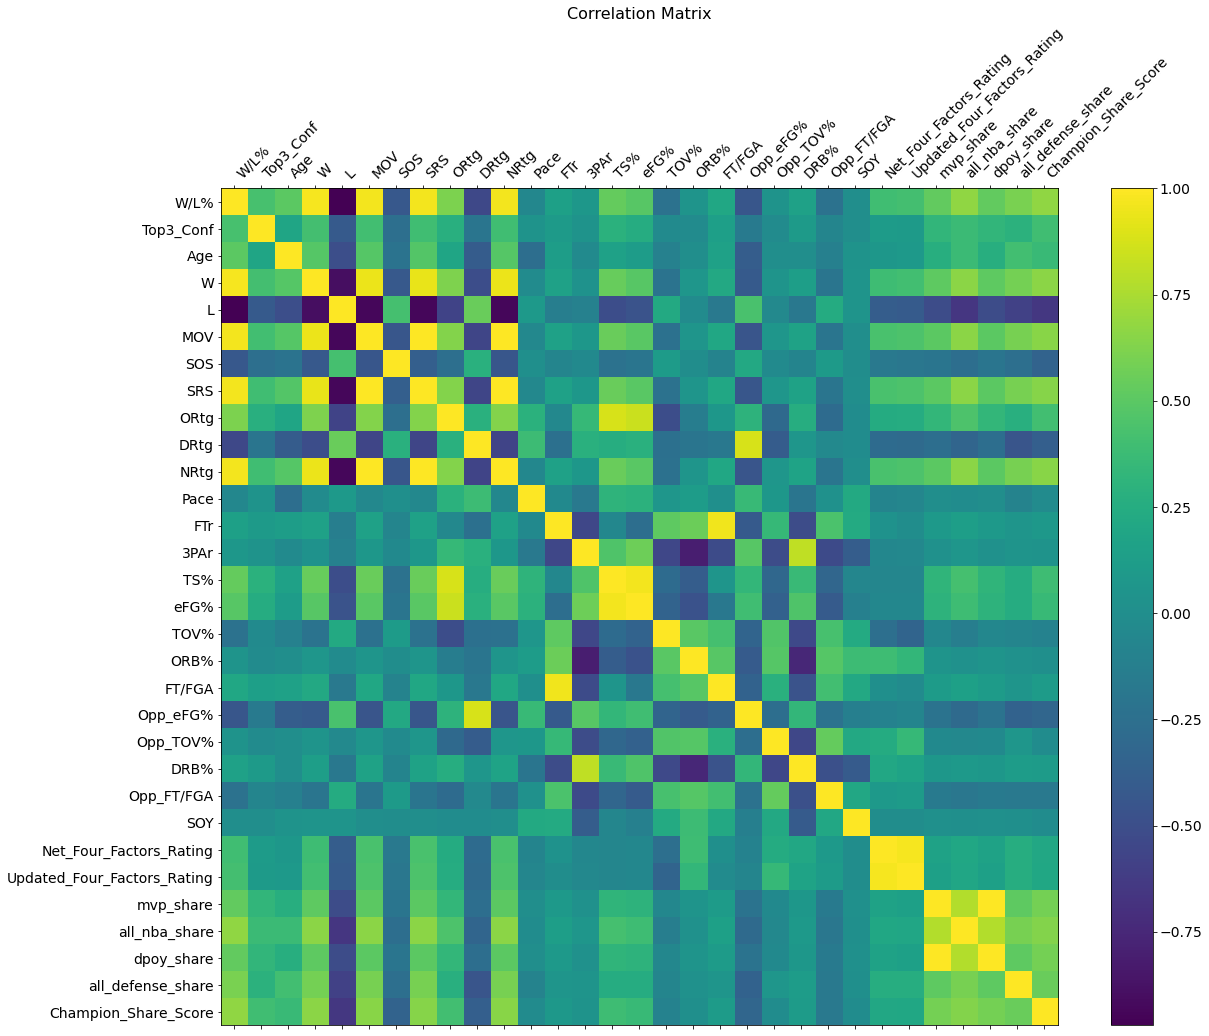

In [11]:
import matplotlib.pyplot as plt

corr_matrix = seasons_df.drop(['Team','season'],1).corr()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=45, ha = 'left')
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [12]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\tmana\AppData\Local\Temp\ipykernel_17304\3601732716.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,W/L%,Top3_Conf,Age,W,L,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,Opp_eFG%,Opp_TOV%,DRB%,Opp_FT/FGA,SOY,Net_Four_Factors_Rating,Updated_Four_Factors_Rating,mvp_share,all_nba_share,dpoy_share,all_defense_share,Champion_Share_Score
W/L%,1.00,0.42,0.51,0.97,-0.97,0.97,-0.43,0.97,0.61,-0.55,0.97,-0.05,0.15,0.07,0.54,0.49,-0.22,0.05,0.20,-0.44,0.04,0.16,-0.23,-0.00,0.40,0.41,0.53,0.68,0.53,0.60,0.67
Top3_Conf,0.42,1.00,0.19,0.41,-0.41,0.40,-0.25,0.39,0.27,-0.20,0.40,0.04,0.10,0.05,0.29,0.25,-0.03,-0.02,0.14,-0.16,-0.02,0.10,-0.08,-0.00,0.11,0.10,0.32,0.37,0.32,0.30,0.40
Age,0.51,0.19,1.00,0.48,-0.50,0.48,-0.22,0.47,0.19,-0.39,0.48,-0.26,0.12,-0.03,0.16,0.12,-0.10,0.01,0.16,-0.39,0.01,0.00,-0.11,0.04,0.08,0.09,0.26,0.37,0.26,0.40,0.36
W,0.97,0.41,0.48,1.00,-0.90,0.94,-0.42,0.94,0.62,-0.50,0.94,-0.02,0.16,0.04,0.54,0.49,-0.22,0.07,0.22,-0.41,0.05,0.13,-0.20,0.05,0.39,0.40,0.51,0.66,0.51,0.59,0.66
L,-0.97,-0.41,-0.50,-0.90,1.00,-0.94,0.42,-0.94,-0.57,0.55,-0.94,0.09,-0.13,-0.10,-0.50,-0.46,0.22,-0.02,-0.17,0.44,-0.04,-0.18,0.24,0.05,-0.39,-0.40,-0.51,-0.66,-0.51,-0.59,-0.65
MOV,0.97,0.40,0.48,0.94,-0.94,1.00,-0.45,1.00,0.63,-0.56,1.00,-0.05,0.15,0.07,0.55,0.50,-0.23,0.05,0.21,-0.45,0.06,0.17,-0.21,-0.00,0.43,0.45,0.50,0.66,0.50,0.59,0.65
SOS,-0.43,-0.25,-0.22,-0.42,0.42,-0.45,1.00,-0.37,-0.25,0.28,-0.44,0.01,-0.07,-0.03,-0.22,-0.21,0.11,-0.00,-0.09,0.22,-0.02,-0.08,0.10,-0.00,-0.18,-0.19,-0.20,-0.26,-0.20,-0.25,-0.34
SRS,0.97,0.39,0.47,0.94,-0.94,1.00,-0.37,1.00,0.63,-0.56,1.00,-0.05,0.15,0.07,0.55,0.50,-0.23,0.06,0.21,-0.45,0.06,0.17,-0.20,-0.00,0.43,0.45,0.50,0.66,0.50,0.59,0.64
ORtg,0.61,0.27,0.19,0.62,-0.57,0.63,-0.25,0.63,1.00,0.28,0.63,0.29,-0.05,0.35,0.88,0.84,-0.50,-0.13,0.07,0.30,-0.30,0.26,-0.28,-0.01,0.24,0.25,0.34,0.45,0.34,0.27,0.40
DRtg,-0.55,-0.20,-0.39,-0.50,0.55,-0.56,0.28,-0.56,0.28,1.00,-0.56,0.38,-0.24,0.28,0.26,0.28,-0.24,-0.21,-0.18,0.88,-0.40,0.06,-0.05,-0.01,-0.28,-0.29,-0.26,-0.33,-0.26,-0.45,-0.38


In [13]:
corr_series = seasons_df.corrwith(seasons_df["Champion_Share_Score"])
selected_features = list(corr_series[corr_series > 0].index)
selected_features.insert(1,'Conference')
selected_features.insert(0,'season')
selected_features.insert(0,'Team')
print(selected_features)

['Team', 'season', 'W/L%', 'Conference', 'Top3_Conf', 'Age', 'W', 'MOV', 'SRS', 'ORtg', 'NRtg', 'FTr', '3PAr', 'TS%', 'eFG%', 'ORB%', 'FT/FGA', 'DRB%', 'Net_Four_Factors_Rating', 'Updated_Four_Factors_Rating', 'mvp_share', 'all_nba_share', 'dpoy_share', 'all_defense_share', 'Champion_Share_Score']


In [14]:
all_seasons_df = seasons_df.loc[:,selected_features]
all_seasons_df.shape

(1224, 25)

In [47]:
!pip install imblearn

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             ndcg_score, r2_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
import random
import sys

RANDOM_SEED = 12345
random.seed(RANDOM_SEED)

In [91]:
all_seasons_df.sort_values(by=['season'], ascending=False, inplace=True)

train_df = all_seasons_df[all_seasons_df['season'] <= 2020]
test_df = all_seasons_df[all_seasons_df['season'] > 2020] 

X_train = train_df.drop(['Team','season','Champion_Share_Score'], axis=1)
y_train = train_df['Champion_Share_Score']
X_test = test_df.drop(['Team','season','Champion_Share_Score'], axis=1)
y_test = test_df['Champion_Share_Score']

In [92]:
numeric_col = [col for col in X_train.columns if col not in ['Top3_Conf','Conference']]
numeric_pipe = Pipeline(steps=[('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse=False), ['Top3_Conf','Conference']),
                                               ('num', numeric_pipe, numeric_col)])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

C:\Users\tmana\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [93]:
X_test

array([[ 0.        ,  1.        ,  1.        , ...,  1.76554883,
         2.34376499,  5.11829596],
       [ 0.        ,  1.        ,  1.        , ...,  2.28050877,
         0.85568758,  1.18813276],
       [ 1.        ,  0.        ,  0.        , ..., -0.63152136,
        -0.42241572, -0.06419043],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -0.69532171,
        -0.42241572, -0.65038427],
       [ 1.        ,  0.        ,  1.        , ..., -0.66797871,
        -0.42241572, -0.27735183],
       [ 1.        ,  0.        ,  1.        , ..., -0.17124743,
        -0.39959244, -0.63706168]])

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error

reg1 = svm.SVR(kernel = 'rbf')
reg2 = LinearRegression()
reg3 = RandomForestRegressor()
reg4 = XGBRegressor()
reg5 = LinearRegression()
reg6 = GradientBoostingRegressor()

score1 = cross_val_score(reg1,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')
score2 = cross_val_score(reg2,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')
score3 = cross_val_score(reg3,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')
score4 = cross_val_score(reg4,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')
score5 = cross_val_score(reg5,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')
score6 = cross_val_score(reg6,X_train,y_train,cv = 5, scoring = 'neg_mean_absolute_error')

print('SVM mean absolute error: ',np.mean(-1*score1))
print('Linear Regression mean absolute error: ',np.mean(-1*score2))
print('Random Forest mean absolute error: ',np.mean(-1*score3))
print('XGBoost mean absolute error: ',np.mean(-1*score4))
print('Linear Regression mean absolute error: ',np.mean(-1*score5))
print('GradientBoosting Regressor mean absolute error: ',np.mean(-1*score6))

SVM mean absolute error:  0.13194028809677633
Linear Regression mean absolute error:  0.12550546037571253
Random Forest mean absolute error:  0.10765426282925943
XGBoost mean absolute error:  0.11551822781746854
Linear Regression mean absolute error:  0.12550546037571253
GradientBoosting Regressor mean absolute error:  0.11186194557770954


In [157]:
all_seasons_df.sort_values(by=['season'], ascending=False, inplace=True)

seasons_till_2020 = all_seasons_df[all_seasons_df['season'] <= 2020]
seasons_last3 = all_seasons_df[all_seasons_df['season'] > 2020] 

In [158]:
df_train = seasons_till_2020[seasons_till_2020['season'] <= 2003]
df_test = seasons_till_2020[seasons_till_2020['season'] > 2003]

extra_col = ['Team', 'season', 'Champion_Share_Score']
df_train_extra = df_train[extra_col]
df_test_extra = df_test[extra_col]
seasons_last3_extra = seasons_last3[extra_col]

train_labels = df_train_extra['Champion_Share_Score'].values
test_labels = df_test_extra['Champion_Share_Score'].values

for col in extra_col:
    del df_train[col]
    del df_test[col]
    del seasons_last3[col]

In [159]:
numeric_col = [col for col in df_train.columns if col not in ['Top3_Conf','Conference']]
numeric_pipe = Pipeline(steps=[('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse=False), ['Top3_Conf','Conference']),
                                               ('num', numeric_pipe, numeric_col)])

train_features = preprocessor.fit_transform(df_train)
test_features = preprocessor.transform(df_test)
last_features = preprocessor.transform(seasons_last3)

header_names = [col.split("__")[1] for col in preprocessor.get_feature_names_out()]

C:\Users\tmana\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [160]:
df_test_extra.reset_index(drop=True, inplace=True)
df_test = pd.concat([pd.DataFrame(data=test_features, columns=header_names), df_test_extra], axis=1)

seasons_last3_extra.reset_index(drop=True, inplace=True)
seasons_last3 = pd.concat([pd.DataFrame(data=last_features, columns=header_names), seasons_last3_extra], axis=1)

In [98]:
def fit_and_evaluate(clf, param) -> list:
    clf.set_params(**param)
    clf.fit(train_features, train_labels)
                            
    test_predict = clf.predict(test_features)
    r2 = r2_score(test_labels, test_predict)
    mae = mean_absolute_error(test_labels, test_predict)
    mse = mean_squared_error(test_labels, test_predict)
    rmse = mean_squared_error(test_labels, test_predict, squared=False)
    
    ndcg = []
    for season in df_test['season'].unique():
        df_ndcg = df_test[df_test['season'] == season].copy()
        df_ndcg.sort_values(by=['Champion_Share_Score'], ascending=False, inplace=True)
        test_labels_ndcg = df_ndcg.pop('Champion_Share_Score')
        del df_ndcg['Team']
        del df_ndcg['season']
        
        test_features_ndcg = df_ndcg.to_numpy()
        test_predict_ndcg = clf.predict(test_features_ndcg)
        
        ndcg_score_ = ndcg_score(y_true=[test_labels_ndcg], y_score=[test_predict_ndcg], k=5) 
        ndcg.append(ndcg_score_)                
        
    return [clf.__class__.__name__, r2, mae, mse, rmse, np.mean(ndcg), param.keys(), param.values()]

In [165]:
list_grid = []

clf = GradientBoostingRegressor(criterion="friedman_mse",min_samples_split=5, min_samples_leaf=5, max_features=3)
print(clf.__class__.__name__)

for max_depth in tqdm(np.arange(3, 11, 1)):
        sys.stdout.write(f"\rmax_depth: {max_depth}/10...")
        for n_estimators in [10, 20, 50, 100]:
                for min_samples_split in [5, 7, 9]:
                        for min_samples_leaf in np.arange(3, 10, 1):
                                for max_features in np.arange(3, 15, 1): 
                                        param = {"max_depth": max_depth,
                                                "n_estimators": n_estimators,
                                                "min_samples_split": min_samples_split,
                                                "min_samples_leaf": min_samples_leaf, 
                                                "max_features": max_features}
                                        list_grid.append(fit_and_evaluate(clf, param))  

GradientBoostingRegressor


  0%|          | 0/8 [00:00<?, ?it/s]

max_depth: 10/10...

In [190]:
df = pd.DataFrame(data=list_grid, columns=["clf", "R2", "MAE", "MSE", "RMSE", "NDCG", "param.keys", "param.values"], index=None)
df.sort_values(by=["NDCG"], ascending=False, inplace=True)
df[df['clf'] == "GradientBoostingRegressor"].head(10)

,clf,R2,MAE,MSE,RMSE,NDCG,param.keys,param.values
135,GradientBoostingRegressor,0.489629,0.131996,0.037368,0.193308,0.863276,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(3, 10, 7, 7, 6)"
4104,GradientBoostingRegressor,0.506042,0.129014,0.036166,0.190174,0.858926,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(7, 10, 5, 9, 3)"
3402,GradientBoostingRegressor,0.553473,0.111537,0.032693,0.180813,0.855349,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(6, 20, 7, 6, 9)"
221,GradientBoostingRegressor,0.537130,0.127813,0.033890,0.184092,0.851420,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(3, 10, 9, 7, 8)"
85,GradientBoostingRegressor,0.516199,0.129444,0.035422,0.188208,0.849313,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(3, 10, 7, 3, 4)"
2666,GradientBoostingRegressor,0.593831,0.117389,0.029738,0.172448,0.848102,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(5, 50, 7, 8, 5)"
1142,GradientBoostingRegressor,0.532982,0.125770,0.034194,0.184915,0.847633,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(4, 10, 7, 7, 5)"
3504,GradientBoostingRegressor,0.596966,0.112382,0.029509,0.171782,0.847303,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(6, 20, 9, 8, 3)"
5256,GradientBoostingRegressor,0.547322,0.126242,0.033144,0.182054,0.846807,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(8, 10, 9, 7, 3)"
2160,GradientBoostingRegressor,0.527711,0.128387,0.034580,0.185956,0.846635,"(max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)","(5, 10, 7, 8, 3)"


In [263]:
model = GradientBoostingRegressor(n_estimators=10, criterion="friedman_mse", max_depth=5, min_samples_split=7, min_samples_leaf=7, max_features=6)
model.fit(train_features,train_labels)

df_n_victory_list = []
ndcg = [] 
for season_n in seasons_last3['season'].unique():
        df_n = seasons_last3[seasons_last3['season'] == season_n].copy()
        names_n = df_n['Team'].values
        df_n.drop(['season', 'Team'], axis="columns", inplace=True)
        y_true = df_n.pop('Champion_Share_Score')
        feature_n = df_n.to_numpy()
        del df_n

        prediction = model.predict(feature_n)
        ndcg_score_ = ndcg_score(y_true=[y_true], y_score=[prediction], k=5) 
        ndcg.append(ndcg_score_)
        
        df_n_victory = pd.DataFrame(data=feature_n, index=None, columns=header_names)
        df_n_victory['season'] = season_n
        df_n_victory['Teams'] = names_n
        df_n_victory['Champion_Shares_in_%'] = prediction * 100
        df_n_victory.sort_values(by=['Champion_Shares_in_%'], ascending=False, ignore_index=True, inplace=True)
        df_n_victory_list.append(df_n_victory)
        
        print(season_n)
        print(df_n_victory[['Teams', 'Champion_Shares_in_%']].head(5))
        print("=============================================================================")
        print("============================================================================\n")

print("NDCG-Score:", np.mean(ndcg))
df_n_victory_list = pd.concat(df_n_victory_list, ignore_index=True)
df_n_victory_list.to_csv("champ_predict.csv", index=False, encoding="utf-8-sig")

2023
  Teams  Champion_Shares_in_%
0   MIL             46.914838
1   PHI             40.308490
2   BOS             36.410932
3   DEN             31.796589
4   SAC             31.656783

2022
  Teams  Champion_Shares_in_%
0   MIL             33.324931
1   MEM             33.077778
2   DEN             31.198267
3   BOS             30.670947
4   PHI             30.015417

2021
  Teams  Champion_Shares_in_%
0   PHI             43.676650
1   DEN             38.984754
2   MIL             33.690044
3   PHO             31.536830
4   BRK             31.515784

NDCG-Score: 0.5912009129034206


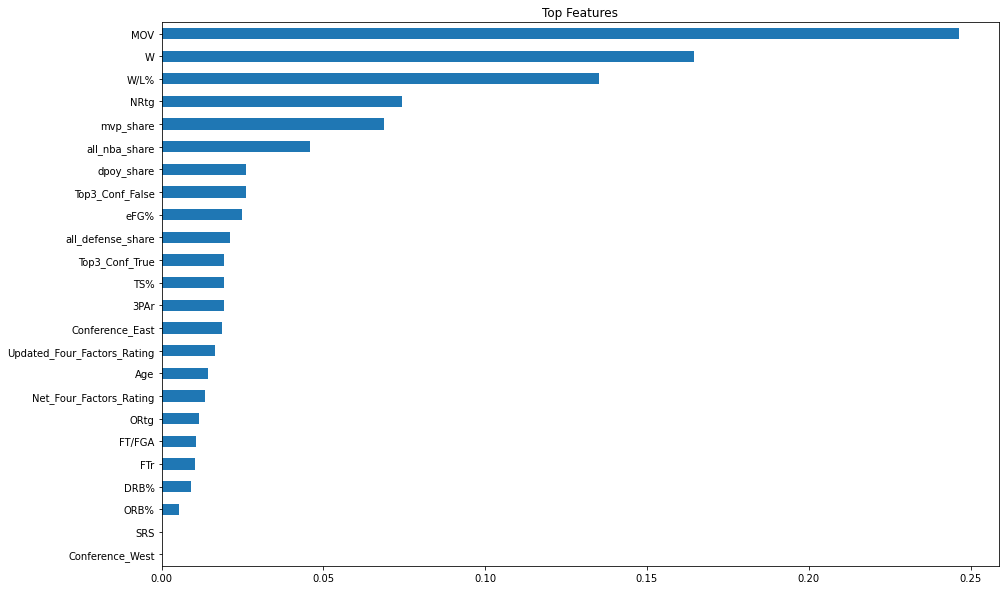

In [264]:
top_features = pd.Series(clf.feature_importances_, index = header_names).sort_values()
top_features.plot(kind="barh", figsize=(15, 10), title="Top Features")
plt.show()

In [218]:
clf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-3)
print(clf.__class__.__name__)
for max_depth in np.arange(3, 16, 1):
        sys.stdout.write(f"\rmax_depth: {max_depth}/15...")
        for n_estimators in np.arange(5, 20, 1):
                param = {"max_depth": max_depth,
                        "n_estimators": n_estimators}
                list_grid.append(fit_and_evaluate(clf, param))

                
clf = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-3, verbosity=0)
print()
print(clf.__class__.__name__)
for max_depth in np.arange(3, 11, 1):
        sys.stdout.write(f"\rmax_depth: {max_depth}/10...")
        for n_estimators in [10, 20, 50, 100]:
                for learning_rate in [0.1, 0.2, 0.3]:
                        for subsample in np.arange(0.4, 1.01, 0.1):
                                for colsample_bytree in np.arange(0.4, 1.01, 0.1): 
                                        param = {"max_depth": max_depth,
                                                "n_estimators": n_estimators,
                                                "learning_rate": learning_rate,
                                                "subsample": subsample, 
                                                "colsample_bytree": colsample_bytree}
                                        list_grid.append(fit_and_evaluate(clf, param))  

RandomForestRegressor
max_depth: 15/15...
XGBRegressor
max_depth: 10/10...

In [220]:
df = pd.DataFrame(data=list_grid, columns=["clf", "R2", "MAE", "MSE", "RMSE", "NDCG", "param.keys", "param.values"], index=None)
df.sort_values(by=["NDCG"], ascending=False, inplace=True)
df[df['clf'] == "RandomForestRegressor"].head(10)

,clf,R2,MAE,MSE,RMSE,NDCG,param.keys,param.values
8168,RandomForestRegressor,0.571253,0.106746,0.031392,0.177177,0.796924,"(max_depth, n_estimators)","(9, 19)"
8230,RandomForestRegressor,0.528152,0.112002,0.034547,0.185869,0.795955,"(max_depth, n_estimators)","(14, 6)"
8111,RandomForestRegressor,0.502546,0.118558,0.036422,0.190846,0.791466,"(max_depth, n_estimators)","(6, 7)"
8241,RandomForestRegressor,0.581434,0.105758,0.030646,0.175060,0.791286,"(max_depth, n_estimators)","(14, 17)"
8257,RandomForestRegressor,0.572131,0.108156,0.031327,0.176995,0.791207,"(max_depth, n_estimators)","(15, 18)"
8256,RandomForestRegressor,0.573027,0.107603,0.031262,0.176810,0.791024,"(max_depth, n_estimators)","(15, 17)"
8170,RandomForestRegressor,0.553622,0.107677,0.032682,0.180783,0.790824,"(max_depth, n_estimators)","(10, 6)"
8239,RandomForestRegressor,0.577891,0.106583,0.030906,0.175800,0.786347,"(max_depth, n_estimators)","(14, 15)"
8183,RandomForestRegressor,0.571167,0.107455,0.031398,0.177194,0.786129,"(max_depth, n_estimators)","(10, 19)"
8243,RandomForestRegressor,0.583140,0.105591,0.030521,0.174703,0.784765,"(max_depth, n_estimators)","(14, 19)"


In [272]:
clf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-3, max_depth=10, n_estimators=20)
clf.fit(train_features, train_labels) 

df_n_victory_list = []
ndcg = [] 
for season_n in seasons_last3['season'].unique():
        df_n = seasons_last3[seasons_last3['season'] == season_n].copy()
        names_n = df_n['Team'].values
        df_n.drop(['season', 'Team'], axis="columns", inplace=True)
        y_true = df_n.pop('Champion_Share_Score')
        feature_n = df_n.to_numpy()
        del df_n

        prediction = clf.predict(feature_n)
        ndcg_score_ = ndcg_score(y_true=[y_true], y_score=[prediction], k=5) 
        ndcg.append(ndcg_score_)
        
        df_n_victory = pd.DataFrame(data=feature_n, index=None, columns=header_names)
        df_n_victory['season'] = season_n
        df_n_victory['Teams'] = names_n
        df_n_victory['Champion_Shares_in_%'] = prediction * 100
        df_n_victory.sort_values(by=['Champion_Shares_in_%'], ascending=False, ignore_index=True, inplace=True)
        df_n_victory_list.append(df_n_victory)
        
        print(season_n)
        print(df_n_victory[['Teams', 'Champion_Shares_in_%']].head(5))
        print("=============================================================================")
        print("============================================================================\n")

print("NDCG-Score:", np.mean(ndcg))
df_n_victory_list = pd.concat(df_n_victory_list, ignore_index=True)
df_n_victory_list.to_csv("champ_predict.csv", index=False, encoding="utf-8-sig")

2023
  Teams  Champion_Shares_in_%
0   DEN             64.041667
1   PHI             60.666667
2   SAC             59.533333
3   MIL             57.680556
4   CLE             54.750000

2022
  Teams  Champion_Shares_in_%
0   BOS             62.791667
1   DEN             60.667468
2   MIL             60.666667
3   PHI             56.473558
4   DAL             47.825000

2021
  Teams  Champion_Shares_in_%
0   MIL             57.500000
1   DEN             55.000000
2   PHO             47.982242
3   DAL             46.062153
4   LAC             44.541667

NDCG-Score: 0.7074035881091136


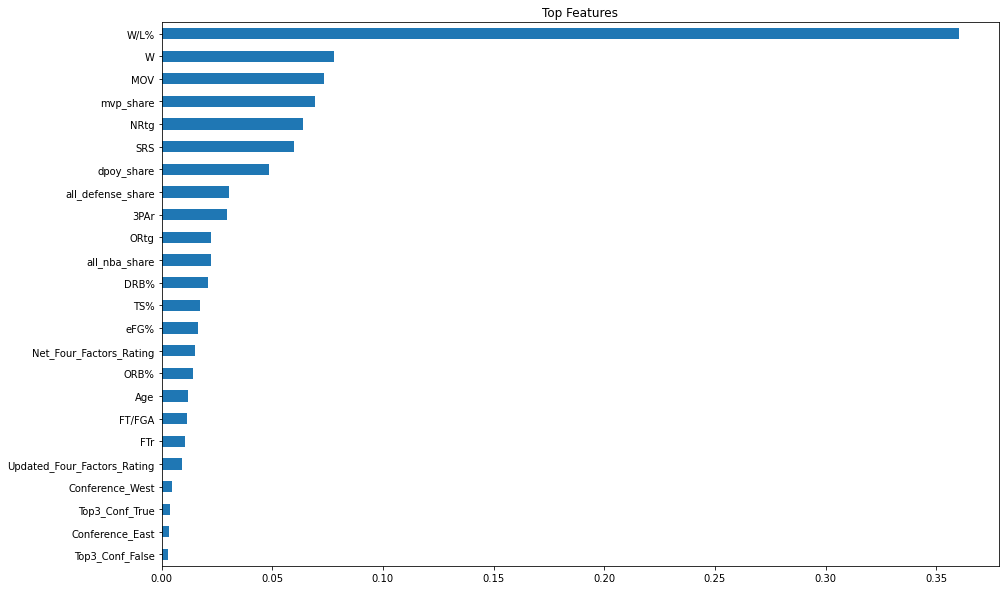

In [258]:
top_features = pd.Series(clf.feature_importances_, index = header_names).sort_values()
top_features.plot(kind="barh", figsize=(15, 10), title="Top Features")
plt.show()

In [259]:
pd.set_option('max_colwidth', None)
df[df['clf'] == "XGBRegressor"].head(10)

,clf,R2,MAE,MSE,RMSE,NDCG,param.keys,param.values
8581,XGBRegressor,0.571185,0.118103,0.031397,0.177191,0.835491,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 50, 0.1, 0.7999999999999999, 0.4)"
8571,XGBRegressor,0.532006,0.131430,0.034265,0.185108,0.821024,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 50, 0.1, 0.6, 0.7999999999999999)"
8424,XGBRegressor,0.544030,0.125813,0.033385,0.182715,0.818095,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 20, 0.1, 0.6, 0.7999999999999999)"
8475,XGBRegressor,0.514691,0.137108,0.035533,0.188502,0.815960,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 20, 0.2, 0.6, 0.9999999999999999)"
8728,XGBRegressor,0.532040,0.125030,0.034263,0.185102,0.814298,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 100, 0.1, 0.7999999999999999, 0.4)"
8419,XGBRegressor,0.566687,0.118351,0.031726,0.178118,0.812910,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 20, 0.1, 0.5, 0.9999999999999999)"
8279,XGBRegressor,0.451362,0.136785,0.040170,0.200424,0.812349,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 10, 0.1, 0.6, 0.9999999999999999)"
8272,XGBRegressor,0.497459,0.132751,0.036795,0.191819,0.811895,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 10, 0.1, 0.5, 0.9999999999999999)"
8301,XGBRegressor,0.467950,0.138652,0.038955,0.197371,0.811090,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 10, 0.1, 0.9999999999999999, 0.4)"
8265,XGBRegressor,0.497441,0.131775,0.036796,0.191823,0.808297,"(max_depth, n_estimators, learning_rate, subsample, colsample_bytree)","(3, 10, 0.1, 0.4, 0.9999999999999999)"


In [261]:
clf = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-3, verbosity=0, max_depth=3, n_estimators=20, learning_rate=0.2, subsample=0.9, colsample_bytree=0.6)
clf.fit(train_features, train_labels) 

df_n_victory_list = []
ndcg = [] 
for season_n in seasons_last3['season'].unique():
        df_n = seasons_last3[seasons_last3['season'] == season_n].copy()
        names_n = df_n['Team'].values
        df_n.drop(['season', 'Team'], axis="columns", inplace=True)
        y_true = df_n.pop('Champion_Share_Score')
        feature_n = df_n.to_numpy()
        del df_n

        prediction = clf.predict(feature_n)
        ndcg_score_ = ndcg_score(y_true=[y_true], y_score=[prediction], k=5) 
        ndcg.append(ndcg_score_)
        
        df_n_victory = pd.DataFrame(data=feature_n, index=None, columns=header_names)
        df_n_victory['season'] = season_n
        df_n_victory['Teams'] = names_n
        df_n_victory['Champion_Shares_in_%'] = prediction * 100
        df_n_victory.sort_values(by=['Champion_Shares_in_%'], ascending=False, ignore_index=True, inplace=True)
        df_n_victory_list.append(df_n_victory)
        
        print(season_n)
        print(df_n_victory[['Teams', 'Champion_Shares_in_%']].head(5))
        print("=============================================================================")
        print("============================================================================\n")

print("NDCG-Score:", np.mean(ndcg))
df_n_victory_list = pd.concat(df_n_victory_list, ignore_index=True)
df_n_victory_list.to_csv("champ_predict.csv", index=False, encoding="utf-8-sig")

2023
  Teams  Champion_Shares_in_%
0   PHI             81.493797
1   MIL             77.215187
2   DEN             69.831085
3   CLE             61.068871
4   BOS             59.162300

2022
  Teams  Champion_Shares_in_%
0   MIA             70.661255
1   BOS             64.723412
2   MIL             62.914478
3   GSW             59.891232
4   UTA             59.714352

2021
  Teams  Champion_Shares_in_%
0   PHI             77.458237
1   MIL             73.185204
2   DEN             72.423843
3   LAC             58.800602
4   BRK             57.842266

NDCG-Score: 0.7049566300928123


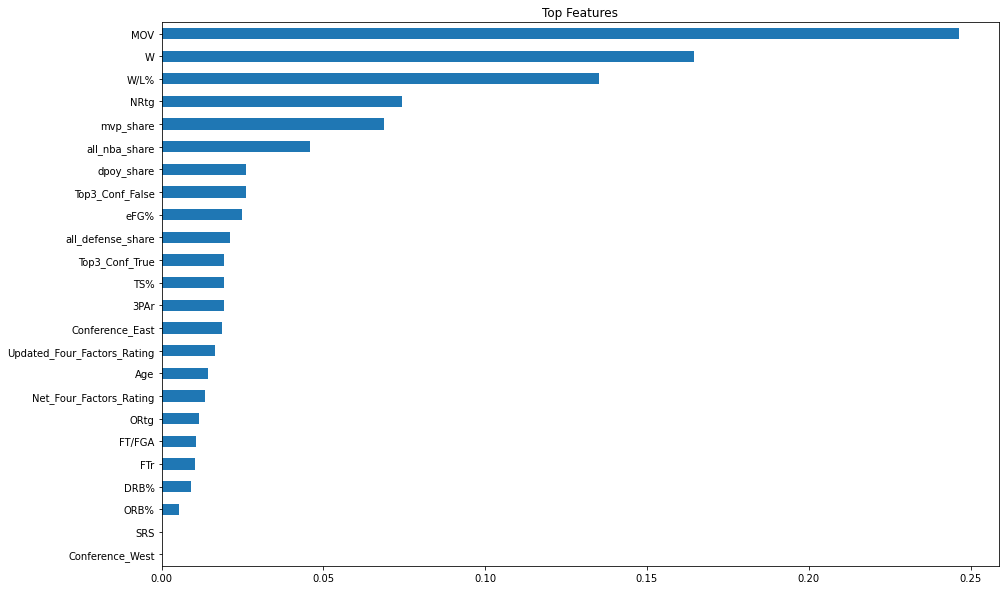

In [262]:
top_features = pd.Series(clf.feature_importances_, index = header_names).sort_values()
top_features.plot(kind="barh", figsize=(15, 10), title="Top Features")
plt.show()